# Quantum Neural Networks

In this notebook we will extend the usage of trainable quantum circuits so that similar to neural networks, the outcome of the circuit itself provides the classification to be performed. We already know that there could be blocks encoding our data (feature maps), blocks containing free parameters (ansatz) and how those parameters can be trained.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import numpy as np
from sklearn.datasets import load_iris

iris = load_iris()

X_idx = np.where(iris.target > 0)
X = iris.data[X_idx]
Y = iris.target[X_idx]

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
from sklearn.model_selection import train_test_split

features = X_scaled.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.33, random_state=42)

Done! Now we can start creating out QNN structure. First we need something to embed the data into a quantum state.

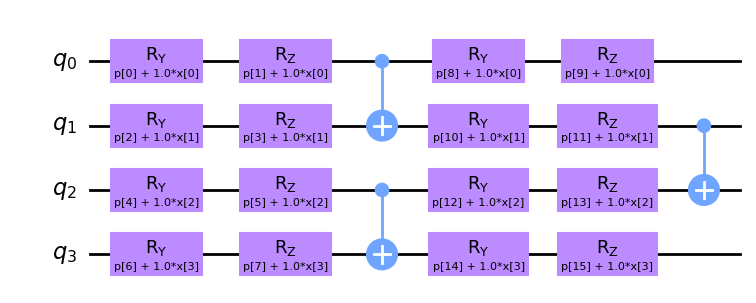

In [5]:
from squlearn.encoding_circuit import YZ_CX_EncodingCircuit

feature_map = YZ_CX_EncodingCircuit(num_qubits = features, num_features = features, num_layers = 2)
feature_map.draw("mpl", style="clifford")

Now we will select a fully parameterized circuit (no data embedded).

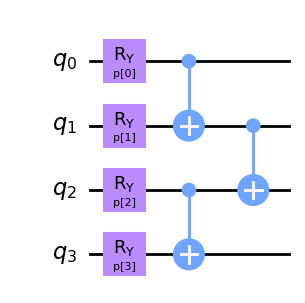

In [6]:
from squlearn.encoding_circuit import LayeredEncodingCircuit
from squlearn.encoding_circuit.layered_encoding_circuit import Layer

# Template
ansatz = LayeredEncodingCircuit(num_qubits=features, num_features=features)

# Create the layer
layer = Layer(ansatz)
layer.Ry("p")
layer.cx_entangling("NN") # Entangling block

ansatz.add_layer(layer,num_layers=1)

ansatz.draw("mpl", style="clifford")

Now we have composed the $U_{\theta_1}(x)$ feature map and $V(\theta_2)$ parameterized circuit that produce the state $|\Psi(x, \theta)\rangle$. By measuring the observable $O$ we can then evaluate the put of the QNN structure as

$$

f(x,\theta) = \langle \Psi(x, \theta) | O |\Psi(x, \theta)\rangle

$$

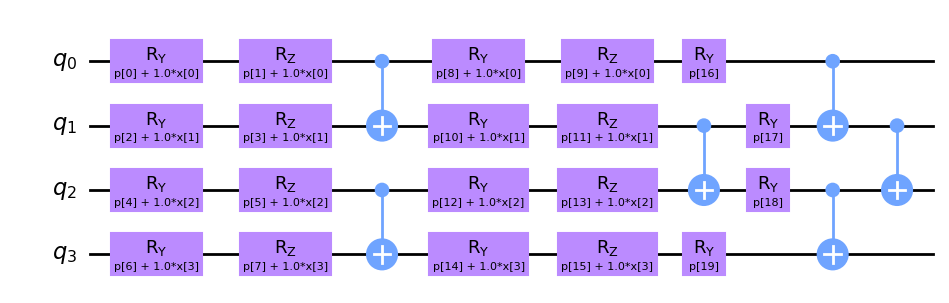

In [7]:
qnn_structure = feature_map + ansatz
qnn_structure.draw('mpl', style="clifford")

A single Z observable over a specific qubit may do the trick. At the end, we know it will return either 1 or -1 so we are fine for binary classiciation tasks.

In [8]:
from squlearn.observables import CustomObservable

observable = CustomObservable(num_qubits=features, operator_string="IIIZ",parameterized=True)
print(observable)

SparsePauliOp(['IIIZ'],
              coeffs=[ParameterExpression(1.0*p[0])])


In [9]:
from squlearn.qnn import QNNClassifier, SquaredLoss
from squlearn.optimizers import Adam
from squlearn import Executor

qnn = QNNClassifier(qnn_structure, observable, Executor("statevector_simulator"), SquaredLoss(), Adam())

In [10]:
qnn.fit(X_train, y_train)

fit: 100%|██████████| 100/100 [04:35<00:00,  2.87s/it]

In [11]:
from sklearn.metrics import classification_report

y_pred = qnn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.82      0.74      0.78        19
           2       0.69      0.79      0.73        14

    accuracy                           0.76        33
   macro avg       0.76      0.76      0.76        33
weighted avg       0.77      0.76      0.76        33



We could try with some data re-uploading...

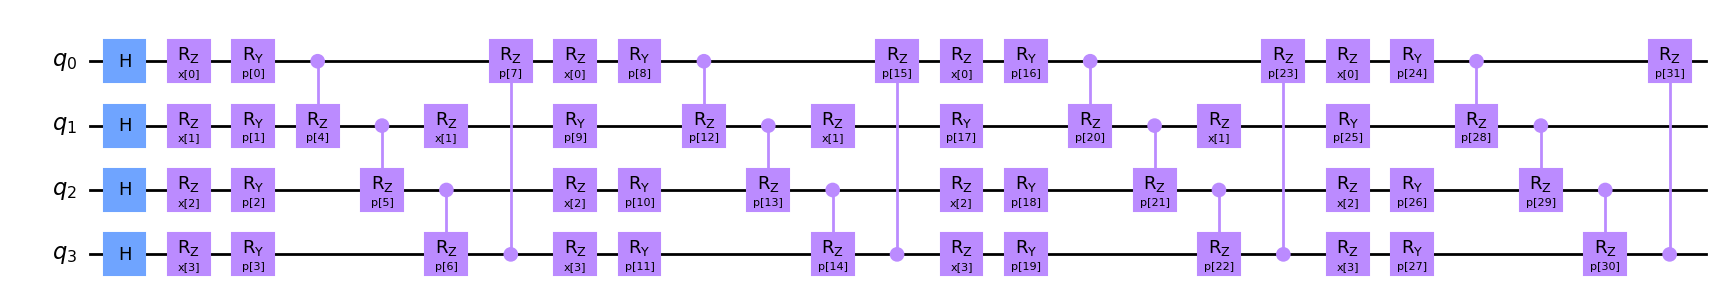

In [12]:
from squlearn.encoding_circuit import HubregtsenEncodingCircuit

full_pqc = HubregtsenEncodingCircuit(num_qubits = features, num_features = features, num_layers = 4)
full_pqc.draw("mpl", style="clifford")

In [13]:
qnn = QNNClassifier(full_pqc, observable, Executor("statevector_simulator"), SquaredLoss(), Adam())
qnn.fit(X_train, y_train)

y_pred = qnn.predict(X_test)
print(classification_report(y_test, y_pred))

fit: 100%|██████████| 100/100 [04:37<00:00,  2.77s/it]
              precision    recall  f1-score   support

           1       0.94      0.84      0.89        19
           2       0.81      0.93      0.87        14

    accuracy                           0.88        33
   macro avg       0.88      0.89      0.88        33
weighted avg       0.89      0.88      0.88        33

